In [11]:
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi
import os
os.chdir('/content/drive/My Drive')
os.getcwd()
os.chdir('/content/drive/My Drive/QML-mnist')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: nvidia-smi: command not found


'/content/drive/My Drive/QML-mnist'

In [12]:
!pip install pennylane==0.23.0
!pip install autoray==0.2.5

correct_labels
12
demodict
4
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 4 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 0 1
<class 'torch.Tensor'> 4 1
<class 'torch.Tensor'> 0 1
<class 'torch.Tensor'> 1 1
<class 'torch.Tensor'> 0 1
<class 'torch.Tensor'> 4 1


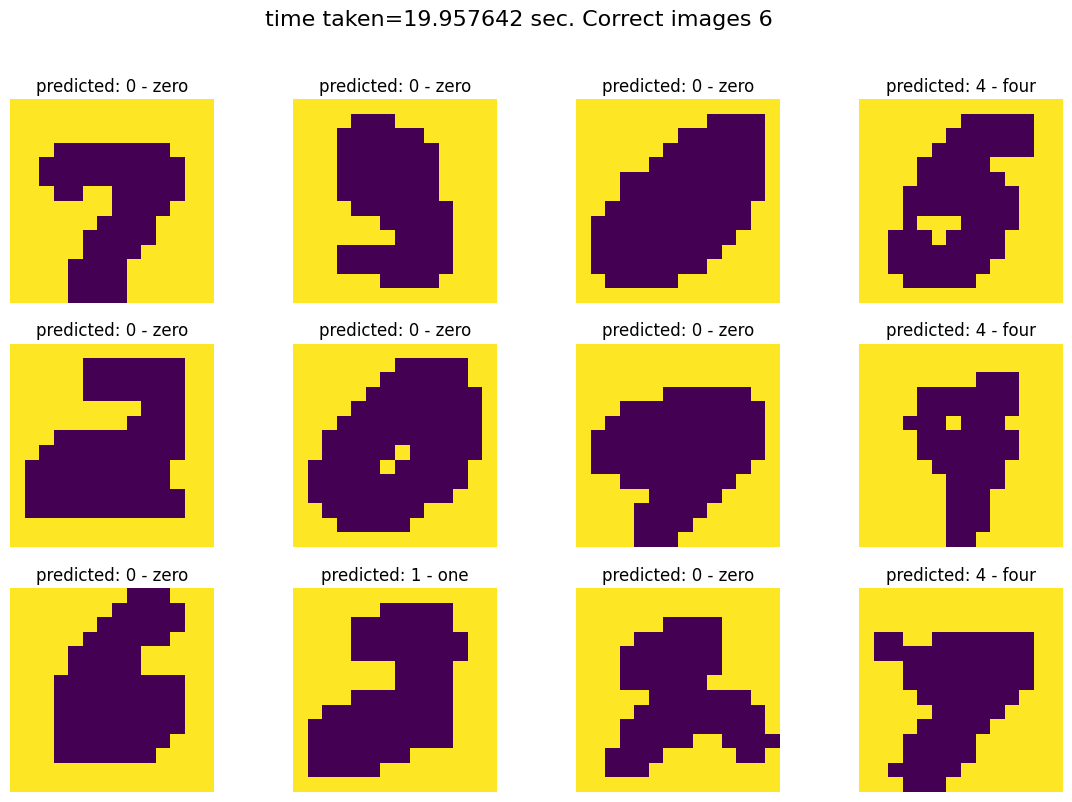

In [13]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pickle

import torch
import numpy as np
import pennylane as qml
from math import ceil
from math import pi


# filtered_classes = ['bear','tiger']
# 定义想要的类别
filtered_classes = [
    '0 - zero',
    '1 - one',
    '2 - two',
    '3 - three',
    '4 - four',
    '5 - five',
    '6 - six',
    '7 - seven',
    '8 - eight',
    '9 - nine'
  ]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

n_qubits = 4
n_layers = 1
#n_class = 2
n_class = 10
n_features = 196
image_x_y_dim = 14
kernel_size = n_qubits
stride = 2
kernel_size=2
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(inputs, weights):
    var_per_qubit = int(len(inputs) / n_qubits) + 1
    encoding_gates = ['RZ', 'RY'] * ceil(var_per_qubit / 2)

    for qub in range(n_qubits):
        qml.Hadamard(wires=qub)
        for i in range(var_per_qubit):
            idx = qub * var_per_qubit + i
            if idx < len(inputs):
                if encoding_gates[i] == 'RZ':
                    qml.RZ(inputs[idx], wires=qub)
                elif encoding_gates[i] == 'RY':
                    qml.RY(inputs[idx], wires=qub)

    for l in range(n_layers):
        for i in range(n_qubits):
            qml.CRZ(weights[l, i], wires=[i, (i + 1) % n_qubits])
        for j in range(n_qubits, 2 * n_qubits):
            qml.RY(weights[l, j], wires=j % n_qubits)

    _expectations = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    return _expectations

class Quanv2d(nn.Module):
    def __init__(self, kernel_size=None, stride=None):
        super(Quanv2d, self).__init__()
        weight_shapes = {"weights": (n_layers, 2 * n_qubits)}
        qnode = qml.QNode(circuit, dev, interface='torch', diff_method='best')
        self.ql1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, X):
        assert len(X.shape) == 4
        bs = X.shape[0]
        XL = []
        for i in range(0, X.shape[2] - 2, stride):
            for j in range(0, X.shape[3] - 2, stride):
                XL.append(self.ql1(torch.flatten(X[:, :, i:i + kernel_size, j:j + kernel_size], start_dim=1)))
        X = torch.cat(XL, dim=1).view(bs,4,6,6)
        return X


class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.ql1 = Quanv2d(kernel_size=kernel_size, stride=stride)
        self.conv1 = nn.Conv2d(4,16,3,stride=1)
        self.fc1 = nn.Linear(16*4*4, n_class * 2)
        self.lr1 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(n_class * 2, n_class)

    def forward(self, X):
        bs = X.shape[0]
        X = X.view(bs, 1, image_x_y_dim, image_x_y_dim)
        X = self.ql1(X) #output(bs, 4, 6, 6)
        X = self.lr1(self.conv1(X))
        X = X.view(bs,-1)
        X = self.fc1(X)
        X = self.lr1(X)
        X = self.fc2(X)
        return X




def demo(model):
    os.chdir('/content/drive/My Drive/QML-mnist')
    with open('demoPic.pkl', 'rb') as fo:
        demodict = pickle.load(fo, encoding='bytes')
    # print(demodict)
    torch.no_grad()
    fig,ax = plt.subplots(3, 4,figsize=(14,9))
    t1=time.time()
    correct=0
    correct_labels=[0]*6+[1]*6

    print("correct_labels")
    print(len(correct_labels))
    print('demodict')
    print(len(demodict))
    for i, origdata in enumerate(demodict[b'data']):

        #origdata=origdata.reshape((3,32*32)).transpose()
        #origdata=origdata.reshape(32,32,3)

        origdata=origdata.reshape((1,14*14)).transpose()
        origdata=origdata.reshape(14,14,1)

######### BELOW:preprocess the origdata for model input and predict using the model #######
######### modify code in this block to predict ######################################
        transform = transforms.Compose([
            transforms.ToPILImage(),  # 将 numpy 数组转换为 PIL 图像
            transforms.Grayscale(num_output_channels=1),  # 转换为单通道灰度图
            transforms.Resize((14, 14)),  # 调整图像尺寸为 14x14
            transforms.ToTensor(),  # 转换为张量
            transforms.Normalize((0.485,), (0.229,))  # 归一化，注意通道数只有1
])
        data=transform(origdata)
        data=data.reshape((1,1,14,14))
        output=model(data)
        pred = output.argmax(dim=1, keepdim=True)

        if(i==12):
          break
        #print('pred')
        #print(pred.item())
        #print('correct_labels')
        #print(correct_labels[i])
        #print(i)
        print(type(pred),pred.item(),correct_labels[i])
        if pred.item()==correct_labels[i]:correct+=1
###############################################################################################
###########################  Do not change the code below #####################################
        ax[i//4][i%4].axis('off')
        ax[i//4][i%4].set_title(f'predicted: {filtered_classes[pred]}')
        ax[i//4][i%4].imshow(origdata)
    t2=time.time()
    fig.suptitle('time taken={:6f} sec. Correct images {}'.format(t2-t1,correct),fontsize=16)
    plt.savefig('ex.png')
    plt.ioff()
    plt.show()
if __name__ == '__main__':
    ######### BELOW: load your model ###########
    model = Net()

    # GPU
    # model.load_state_dict(torch.load('./model/qmodel-mnist2.pth'))
    # CPU
    state_dict = torch.load('./model/qmodel-mnist2.pth', map_location="cpu")
    model.load_state_dict(state_dict)

    model.eval()
    ####################################################
    demo(model)

